In [22]:
import sys
import os

sys.path.append("../../python")
from cdh_utils import fromPRPCDateTime, auc_from_bincounts

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%matplotlib inline

# Importing Historical Data files

Historical Datasets can be created from Adaptive models. They contain all the
values of the predictors at the time of decision plus the associated outcome.

To enable this feature please see the Pega documentation.

Once enabled, the system will start generating datafiles in the repository. These
are in multi-line JSON format.

In this example we use a dataset that is included in the data folder of the 
repository (*hds.zip*). As a prerequisite to using this notebook, please first 
unzip this file into a folder called "hds".

In [23]:
path_to_json = '../../data/hds'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
df = pd.DataFrame()
for i in json_files:
    df = pd.concat([pd.read_json(path_to_json + "/" + i, lines=True), df])
df = df.reset_index(drop=True)

In [24]:
df

,Customer_InCollections,IH_Web_Inbound_Rejected_pyHistoricalOutcomeCount,Param_ExtGroupCreditcards,IH_SMS_Outbound_Accepted_pxLastGroupID,IH_SMS_Outbound_Rejected_pxLastGroupID,Customer_NextReviewDate,IH_Email_Outbound_Loyal_pyHistoricalOutcomeCount,Customer_pyRegion,IH_Web_Inbound_Accepted_pyHistoricalOutcomeCount,Customer_ReviewDate,...,IH_Email_Outbound_Accepted_pyHistoricalOutcomeCount,IH_Email_Outbound_Churned_pxLastGroupID,IH_Web_Inbound_Churned_pxLastGroupID,IH_Web_Inbound_Churned_pxLastOutcomeTime_DaysSince,IH_SMS_Outbound_Loyal_pyHistoricalOutcomeCount,IH_SMS_Outbound_Loyal_pxLastGroupID,IH_SMS_Outbound_Loyal_pxLastOutcomeTime_DaysSince,IH_SMS_Outbound_Churned_pxLastGroupID,IH_SMS_Outbound_Churned_pyHistoricalOutcomeCount,IH_SMS_Outbound_Churned_pxLastOutcomeTime_DaysSince
0,true,46,0.170586,DepositAccounts,DepositAccounts,,NaN,,10.0,,...,2.0,None,CreditCards,18.079945,NaN,None,NaN,CreditCards,1.0,18.064822
1,false,39,0.176587,Account,Account,,1.0,,7.0,,...,2.0,None,None,NaN,NaN,None,NaN,None,NaN,NaN
2,false,45,0.217880,DepositAccounts,Account,,NaN,,5.0,,...,2.0,None,CreditCards,18.064747,NaN,None,NaN,None,NaN,NaN
3,false,41,0.176005,CreditCards,Account,,NaN,,3.0,,...,2.0,None,CreditCards,18.071740,NaN,None,NaN,None,NaN,NaN
4,false,35,0.242137,Customer,Account,,NaN,,5.0,,...,1.0,None,CreditCards,18.071408,NaN,None,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12057,false,29,0.207579,DepositAccounts,DepositAccounts,,NaN,,13.0,,...,3.0,None,None,NaN,NaN,None,NaN,None,NaN,NaN
12058,false,46,0.275122,HomeLoans,Account,,1.0,,6.0,,...,NaN,None,None,NaN,NaN,None,NaN,None,NaN,NaN
12059,true,44,0.167223,DepositAccounts,Bundles,,1.0,,5.0,,...,1.0,None,None,NaN,NaN,None,NaN,None,NaN,NaN
12060,false,37,0.205184,Bundles,AutoLoans,,NaN,,6.0,,...,NaN,None,None,NaN,NaN,None,NaN,None,NaN,NaN


# Fields
    
The dataset contains predictors of various sources such as Customer data, IH predictors, other parameterized predictors as well as the context keys for the model. It also contains the outcomes at decision time.

There will also be some "meta" fields that describe where the data is coming from as
well as an ID so the individual decision can be tied back to a specific version of the
model.

In [25]:
cust_col = []
IH_col = []
param_col = []
dec_col = []
context_col = []
other_col = []
for col in df.columns:
    if 'Customer_' in col: cust_col.append(col)
    elif 'IH_' in col: IH_col.append(col)
    elif 'Param_' in col: param_col.append(col)
    elif 'Decision_' in col: dec_col.append(col)
    elif 'Context_' in col: context_col.append(col)
    else: other_col.append(col)

In [26]:
df[cust_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12062 entries, 0 to 12061
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer_InCollections          12062 non-null  object 
 1   Customer_NextReviewDate         12062 non-null  object 
 2   Customer_pyRegion               12062 non-null  object 
 3   Customer_ReviewDate             12062 non-null  object 
 4   Customer_RiskScore              12062 non-null  object 
 5   Customer_NetWealth              12062 non-null  int64  
 6   Customer_Bankruptcy             12062 non-null  object 
 7   Customer_RelationshipStartDate  12062 non-null  float64
 8   Customer_BalanceTransaction     12062 non-null  object 
 9   Customer_MaritalStatus          12062 non-null  object 
 10  Customer_IsCustomerActive       12062 non-null  object 
 11  Customer_CLV                    12062 non-null  int64  
 12  Customer_WinScore               

In [27]:
df[dec_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12062 entries, 0 to 12061
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Decision_OutcomeTime    12062 non-null  object
 1   Decision_DecisionTime   12062 non-null  object
 2   Decision_SubjectID      12062 non-null  object
 3   Decision_Rank           12062 non-null  int64 
 4   Decision_InteractionID  12062 non-null  int64 
 5   Decision_Outcome        12062 non-null  object
dtypes: int64(2), object(4)
memory usage: 565.5+ KB


In [28]:
df[IH_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12062 entries, 0 to 12061
Data columns (total 36 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   IH_Web_Inbound_Rejected_pyHistoricalOutcomeCount        12062 non-null  int64  
 1   IH_SMS_Outbound_Accepted_pxLastGroupID                  11826 non-null  object 
 2   IH_SMS_Outbound_Rejected_pxLastGroupID                  12062 non-null  object 
 3   IH_Email_Outbound_Loyal_pyHistoricalOutcomeCount        2432 non-null   float64
 4   IH_Web_Inbound_Accepted_pyHistoricalOutcomeCount        11971 non-null  float64
 5   IH_Email_Outbound_Rejected_pxLastGroupID                12062 non-null  object 
 6   IH_Web_Inbound_Accepted_pxLastOutcomeTime_DaysSince     11971 non-null  float64
 7   IH_Web_Inbound_Rejected_pxLastOutcomeTime_DaysSince     12062 non-null  float64
 8   IH_SMS_Outbound_Rejected_pxLastOutco

In [29]:
df[param_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12062 entries, 0 to 12061
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Param_ExtGroupCreditcards   12062 non-null  float64
 1   Param_ExtGroupAutoloans     12062 non-null  int64  
 2   Param_ExtGroupWealthoffers  12062 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 282.8 KB


In [30]:
df[context_col].describe()

,Context_Name,Context_Issue,Context_Direction,Context_Channel,Context_Group
count,12062,12062,12062,12062,12062
unique,49,2,2,3,8
top,IncreaseYourCreditLine,Sales,Outbound,SMS,Account
freq,1120,9033,8681,4561,2049


In [31]:
df[other_col].head()

,positiveSampling,rulesetVersion,id,negativeSampling,dataCenter,rulesetName
0,10,01-01-01,8c8cd96c-bf4f-5f4c-b0ec-b0ff48091906,10,datacenter1,CDHSample-Artifacts
1,10,01-01-01,88ab203b-0ad1-51b5-910a-b5d9b3071b80,10,datacenter1,CDHSample-Artifacts
2,10,01-01-01,7161719c-f3b0-5274-80be-2463dfd1ef33,10,datacenter1,CDHSample-Artifacts
3,10,01-01-01,359e16f4-b066-5d7a-9659-62af49a9c463,10,datacenter1,CDHSample-Artifacts
4,10,01-01-01,644f5f22-4e31-5818-af1a-129dcddfdf0a,10,datacenter1,CDHSample-Artifacts


## Correcting datetime fields

Using the CDH utils library it is easily possible to convert the string datetime fields into actual datetime values. From there, the date value (year, month, day) is extracted from Decision Time field.

In [32]:
df['Decision_DecisionTime'] = [fromPRPCDateTime(i) for i in df['Decision_DecisionTime']]
df['Decision_OutcomeTime'] = [fromPRPCDateTime(i) for i in df['Decision_OutcomeTime']]
df['Day'] = [i.strftime('%Y-%m-%d') for i in df['Decision_DecisionTime']]

In [33]:
df['Customer_Age'] = df['Customer_Age'].astype(float)

# Exploring Data


## Customer Age over Time

The boxplot below shows the Customer Age value over time. The line in the middle of each box represents the median value. It is also possible to see the outliers. 

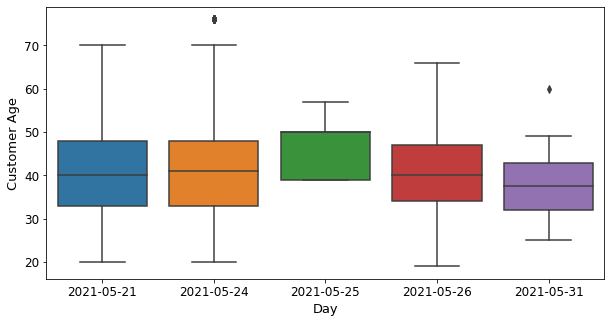

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='Day', y='Customer_Age', data=df.sort_values('Day'))
ax.set_ylabel('Customer Age', fontsize=13)
ax.set_xlabel('Day', fontsize=13)
for i in ax.get_xmajorticklabels()+ax.get_ymajorticklabels():
    i.set_fontsize(12)

## Missing Values

Showing the percentage of missing values per day. Missing values
are a common source of issues in models.

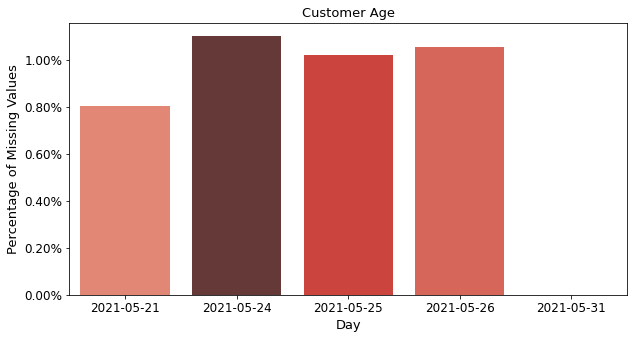

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
df_plot = df[['Customer_Age', 'Day']].groupby('Day').apply(
    lambda x:x['Customer_Age'].isnull().sum()*100/x.shape[0]).reset_index().sort_values('Day')
pal = sns.color_palette("Reds_d", len(df_plot))
rank = df_plot[0].argsort()
sns.barplot(x='Day', y=0, data=df_plot, palette=np.array(pal[::-1])[rank])
ax.set_ylabel('Percentage of Missing Values', fontsize=13)
ax.set_xlabel('Day', fontsize=13)
ax.set_title('Customer Age', fontsize=13)
for i in ax.get_xmajorticklabels()+ax.get_ymajorticklabels():
    i.set_fontsize(12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## Predictor performance (AUC) over time

Since the Historical Dataset contains the outcomes, we can also plot the day-over-day 
predictor performance. We can "bin" the predictor using a simple quantile binning,
then use the number of "positives" and "negatives" to calculate the AUC.

This is not exactly the same binning as ADM is doing but for numeric fields this
will be a good approximation. For symbolic fields the binning should take a 
similar approach as ADM is doing, by grouping labels by z-ratio first.

In [36]:
df = df.sort_values('Customer_Age')
df['Customer_Age_Binned'] = pd.cut(np.array(df.sort_values('Customer_Age')['Customer_Age']), 
                                   bins=20,right = False, include_lowest =True )

In [37]:
df_AUC = df[['Customer_Age_Binned', 'Decision_Outcome', 'Customer_Age', 'Day']].groupby(
    ['Day', 'Customer_Age_Binned', 'Decision_Outcome']).count().rename(columns={'Customer_Age':'count'}).reset_index()

auc_per_day = {}
for day in df_AUC.sort_values('Day')['Day'].unique():
    _df = df_AUC[df_AUC['Day']==day].pivot(index='Customer_Age_Binned', 
                                           columns='Decision_Outcome', values='count').reset_index()
    _df = _df[~((_df['Accepted'].isnull()) & (_df['Rejected'].isnull()))].sort_values('Customer_Age_Binned')
    _df['Accepted'] = _df['Accepted'].fillna(0)
    _df['Rejected'] = _df['Rejected'].fillna(0)
    if _df['Accepted'].sum()==0:
        auc_per_day[day] = 0.5
    else:
        auc_per_day[day] = auc_from_bincounts(_df['Accepted'], _df['Rejected'])
auc_per_day = pd.DataFrame.from_dict(auc_per_day, orient='index').reset_index().rename(columns={0:'AUC', 'index':'Day'})
auc_per_day['AUC (%)'] = auc_per_day['AUC']*100

../../python/cdh_utils.py:127: RuntimeWarning: invalid value encountered in true_divide
  o = np.argsort(-(pos / (pos + neg)))


In [38]:
auc_per_day

,Day,AUC,AUC (%)
0,2021-05-21,0.547377,54.737724
1,2021-05-24,0.552796,55.279615
2,2021-05-25,0.824176,82.417582
3,2021-05-26,0.598652,59.865162
4,2021-05-31,0.500000,50.000000


(50.0, 86.0)

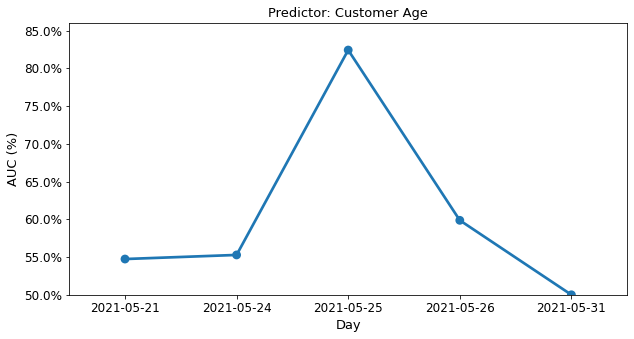

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(x='Day', y='AUC (%)', data=auc_per_day)
ax.set_ylabel('AUC (%)', fontsize=13)
ax.set_xlabel('Day', fontsize=13)
ax.set_title('Predictor: Customer Age', fontsize=13)
for i in ax.get_xmajorticklabels()+ax.get_ymajorticklabels():
    i.set_fontsize(12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylim([50, 86])